<h1>Практическая работа: "Бинарная логистическая регрессия"</h1>

__Задача бинарной классификации__

___Некая фирма провела анализ зависимости расхода денежных средств на рекламу и эффекта от нее. Если эффект присутствовал, 
то в датасете ставилась 1, в противном случае - 0. Результаты были представоены в виде двух DataFrame х и y.<br>
Произыести бинарную классификацию с использованием логистической регрессии.___  

In [1]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Исходные данные: x - расходы на рекламу, Y - объемы продаж
x = pd.DataFrame(np.array([39, 36, 60, 21, 27, 12, 51, 57, 54, 42, 18, 9, 48, 66, 6, 30, 24, 33, 15, 21, 100, 200]))
Y = pd.DataFrame(np.array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]))
#display(x, Y)

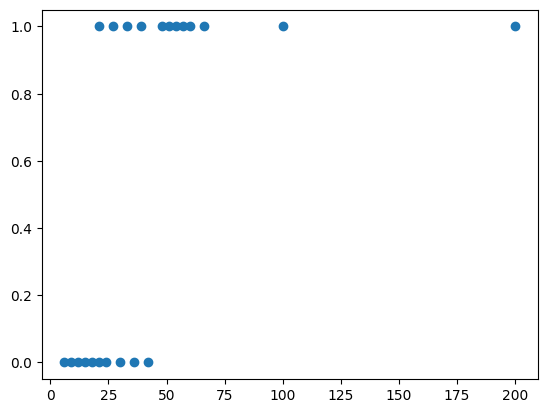

In [3]:
plt.scatter(x,Y)

_Попробуем разделить эти точки прямой линией, отделяющей один класс от другого. 
Модель начинает плохо работать в случае добавления новых точек на больших значениях x:_

In [4]:
a1 = ((x-x.mean())*(Y-Y.mean())).mean()/((x-x.mean())**2).mean()
a0 = Y.mean() - a1*x.mean()
print("Y = ", a0, " + ", a1, " * x")
x_space = np.linspace(6,70,20)
Y_pred = a0.item() + a1.item()*x_space

Y =  0    0.266493
dtype: float64  +  0    0.006333
dtype: float64  * x


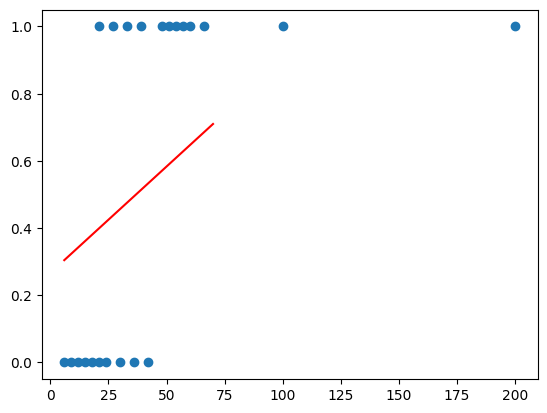

In [5]:
plt.plot(x_space, Y_pred, 'r')
plt.scatter(x, Y)

<h2>Функция логистической регрессии</h2>

__Сигмоида__

Возможное решение упомянутых выше сложностей — пропустить значение линейной регрессии через сигмоиду (sigmoid function), 
которая при любом значении x не выйдет из необходимого нам диапазона от 0 до 1. <br>
<h3>$g(x) = \frac{1}{1+ e^{-x}}$</h3>

 <img src='images/ris1.png' width=320, heigth=240>

<h3>Logistic loss или функция кросс-энтропии</h3>

В модели логистической регрессии мы не можем использовать MSE. Дело в том, 
что если мы поместим результат сигмоиды (представляющей собою нелинейную функцию) в MSE, 
то на выходе получим невыпуклую функцию (non-convex), глобальный минимум которой довольно сложно найти.
 <img src='images/ris2.png' width=520, heigth=240>
    Вместо MSE мы будем использовать функцию логистической ошибки, которую еще называют функцией бинарной кросс-энтропии (log loss, binary cross-entropy loss).

__График и формула функции логистической ошибки__<br>
 <img src='images/ris3.png' width=420, heigth=240>

$J(\theta)=-\frac{1}{n} \sum{y*log(h_{\theta}(x))+(1-y)*log(1-h_{\theta}(x))}$

<h3>Оценка качества модели</h3>

__Матрицa ошибок (confusion matrix)__<br>
 <img src='images/ris4.png' width=420, heigth=240><br>
Доля правильно предсказанных значений называется accuracy. Чтобы ее посчитать, мы берем те значения,
    которые предсказаны верно (TP + TN) и делим на общее количество прогнозов.<br>
    <h3>$accuracy=\frac{TP+TN}{TP+TN+FP+FN}$</h3>

<h2>Конкретизация задачи:</h2>

Реализовать класс модели логистической регрессии с использованием:

а) максимизации логарифмического правдоподобия методом градиентного подъема

б) минимизации функции потерь (кросс-энтропии) методом градиентного спуска

Сравнить результаты (время исполнения и достигнутые значения accuracy и f1) в случаях а и б при одном и том же числе шагов и скорости обучения.

In [6]:
#Реализуем цикл градиентного спуска
class LogisticRegressionGD(object):
    def __init__(self):
        self.a = np.zeros(2).reshape(1, 2)
        
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x @ self.a))
    
    def predict(self, x):
        return self.sigmoid(x)
    
    def coefs(self):
        return self.a
      
    def LogLikelihood(self, x, Y):
        return (Y * np.log(self.predict(x)) + (1 - Y) * np.log(1 - self.predict(x))).sum()

    def CrossEntropy(self, x, Y):
        return (-Y * np.log(self.predict(x)) - (1 - Y) * np.log(1 - self.predict(x))).sum()
    
    def accuracy(self, x, Y):
        return ((self.predict(x) > 0.5)==Y).mean() 

    def fit(self, x, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "LL"):
        self.a = np.zeros (x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dT_a = x.T @(Y - self.predict(x)) / x.shape[0]
                self.a += alpha*dT_a
            elif Rtype == "CE":
                new_error = self.CrossEntropy(x, Y)
                #display(new_error)
                dT_a = -x.T @(Y - self.predict(x)) / x.shape[0]
                self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)
            #if new_error < epsylon:
            #    break
        return steps, errors

In [7]:
x_ = x.copy()

import time

intercept = np.ones((x.shape[0], 1))
x_ = pd.DataFrame(np.concatenate((intercept, x), axis = 1))

In [8]:
start_time_CE = time.time()
regr_CE = LogisticRegressionGD()
steps_CE, errors_CE =  regr_CE.fit(x_, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "CE") 

display(f"Время обучения: {time.time() - start_time_CE} сек.")

start_time_LL = time.time()
regr_LL = LogisticRegressionGD()
steps_LL, errors_LL =  regr_LL.fit(x_, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "LL") 

display(f"Время обучения: {time.time() - start_time_LL} сек.")

'Время обучения: 43.93430137634277 сек.'

'Время обучения: 49.47350358963013 сек.'

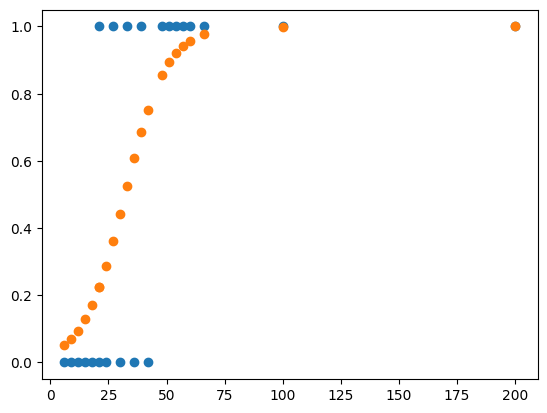

In [9]:
Y_Pred = regr_CE.predict(x_)
plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

In [11]:
display(regr_CE.coefs())
#display(x_)

,0
0,-3.599005
1,0.112157


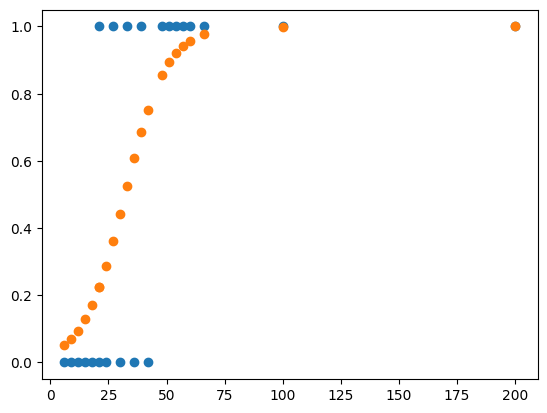

In [12]:
Y_Pred = regr_LL.predict(x_)
plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

In [13]:
display(regr_LL.coefs())
#display(x_)

,0
0,-3.599005
1,0.112157


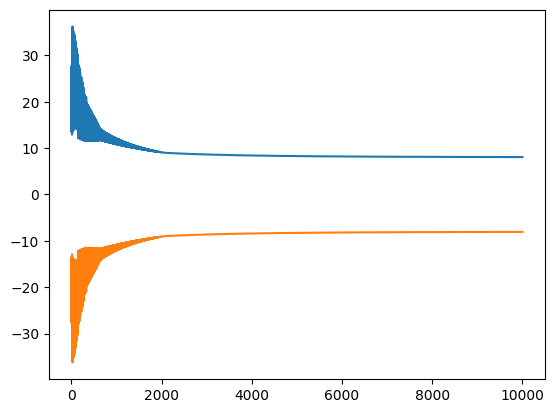

In [14]:
plt.plot(steps_CE, errors_CE)
plt.plot(steps_LL, errors_LL)

In [15]:
print(regr_CE.accuracy(x_, Y))
print(regr_LL.accuracy(x_, Y))

0    0.818182
dtype: float64
0    0.818182
dtype: float64


Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/
Для 151 406 договоров страхования транспортных средств известны значения ряда признаков, в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель, год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);
variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);
variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);
variable_4 - идентификатор года выпуска транспортного средства;
variable_5 - идентификатор страны - производителя транспортного средства;
variable_6 - мощность двигателя в лошадиных силах;
variable_7 - объем двигателя в куб. см;
variable_8 - идентификатор стороны расположения руля (левый или правый);
variable_9 - пробег транспортного средства, покрываемый гарантией производителя;
variable_10 - индикатор действия гарантии на транспортное средство;
variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;
variable_12 - возраст транспортного средства (в мес.);
variable_13 - возраст водителя с максимальным стажем;
variable_14 - коэффициент возраст-стаж;
variable_15 - коэффициент краткосрочности;
variable_16 - коэффициент мощности;
variable_17 - коэффициент "мультидрайв";
variable_18 - территориальный коэффициент;
variable_19 - коэффициент "КНДР";
variable_20 - идентификатор канала продаж;
variable_21 - марка транспортного средства;
variable_22 - модель транспортного средства;
variable_23 - индикатор отечественных транспортных средств;
variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";
variable_25 - индикатор пролонгации;
variable_26 - индикатор совпадения собственника транспортного средства и водителя;
variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";
variable_28 - тип транспортного средства;
target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.


Удалено строк с пропусками: 4877
Размер данных после очистки: (146529, 11)

Форма матрицы признаков X: (146529, 10)
Форма вектора целевой переменной y: (146529, 1)
Распределение классов в y: 
(array([0, 1]), array([134442,  12087]))

Форма X с intercept: (146529, 11)

--- Маленькая выборка для визуализации ---
Форма X_small: (1000, 1)
Уникальные значения y_small: (array([0, 1]), array([925,  75]))

--- Большая выборка для обучения ---
Форма X_big: (146529, 11)

Обучение на маленькой выборке (1 признак, 1000 объектов)

--- Модель CE (градиентный спуск) ---
Время обучения: 0.5171 сек
Коэффициенты: [  46.245      6086.64194496]
Accuracy на обучении: 0.0750

--- Модель LL (градиентный подъем) ---
Время обучения: 0.4852 сек
Коэффициенты: [ 0.05163943 -0.35198768]
Accuracy на обучении: 0.9250


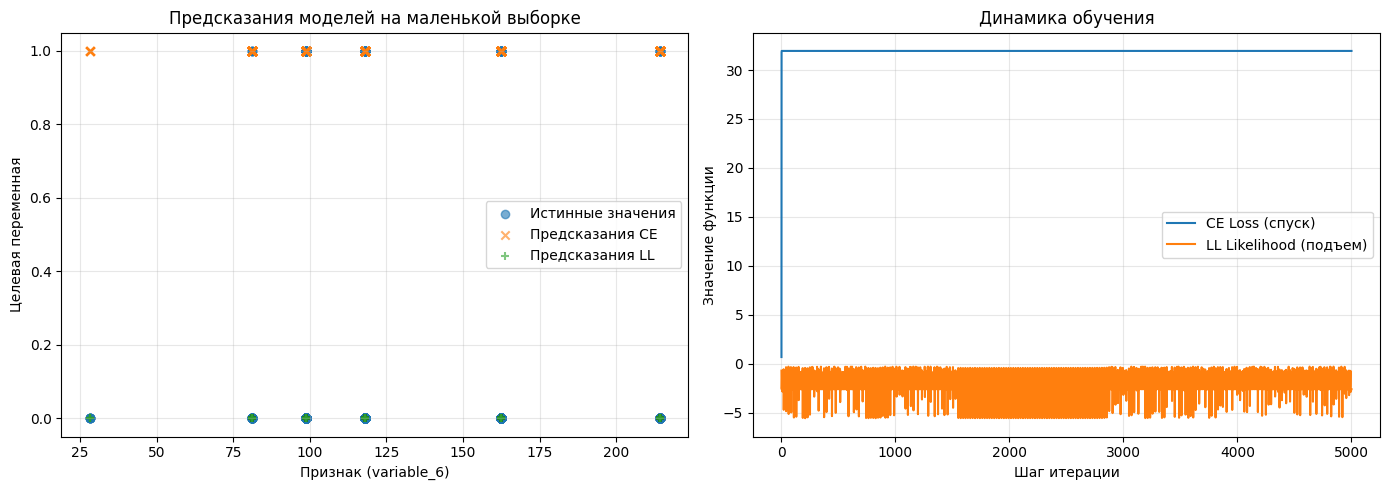


Сравнение методов на большой выборке (все данные)

--- Модель CE (градиентный спуск) ---
Шаг 1000, значение функции: 31.690448
Время обучения: 23.1666 сек
Accuracy: 0.0825
F1-score: 0.1524
Итоговые коэффициенты (первые 5): [  0.91701121  10.47545929 107.65832183 122.57447306  46.16971409]

--- Модель LL (градиентный подъем) ---
Шаг 1000, значение функции: -1.249283
Время обучения: 21.0927 сек
Accuracy: 0.9174
F1-score: 0.0002
Итоговые коэффициенты (первые 5): [ 0.00048401  0.00135096 -0.00606063 -0.01191359 -0.03591776]
ИТОГОВОЕ СРАВНЕНИЕ


,Метод,Время (сек),Accuracy,F1-score
0,Кросс-энтропия (спуск),23.166584,0.082489,0.152406
1,Лог. правдоподобие (подъем),21.092712,0.917450,0.000165


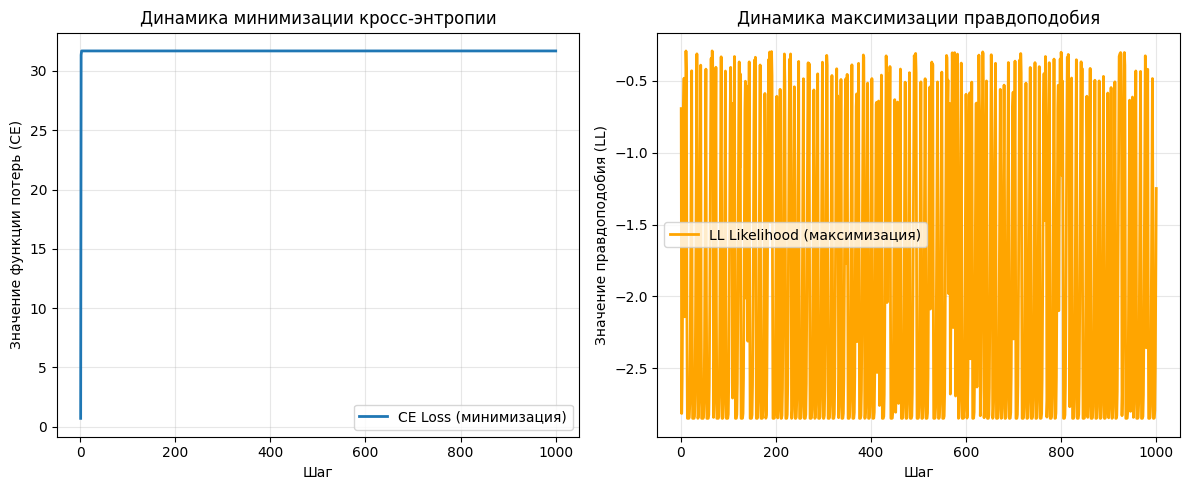

In [13]:
# Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('insclass_train.csv')

cols_to_use = ['variable_4', 'variable_6', 'variable_12', 'variable_13',
               'variable_14', 'variable_16', 'variable_17', 'variable_18',
               'variable_19', 'variable_27', 'target']

# Создадим копию данных только с нужными колонками
df_clean = df_train[cols_to_use].copy()

# Удалим строки, где есть пропуски (NaN)
initial_len = len(df_clean)
df_clean = df_clean.dropna()
print(f"\nУдалено строк с пропусками: {initial_len - len(df_clean)}")
print(f"Размер данных после очистки: {df_clean.shape}")

# Разделим данные на признаки (X) и целевую переменную (y)
X_all = df_clean.drop('target', axis=1).values.astype(np.float64)
y_all = df_clean['target'].values.astype(np.int64).reshape(-1, 1)

print(f"\nФорма матрицы признаков X: {X_all.shape}")
print(f"Форма вектора целевой переменной y: {y_all.shape}")
print(f"Распределение классов в y: \n{np.unique(y_all, return_counts=True)}")

class LogisticRegressionGD:
    """
    Класс для бинарной логистической регрессии, обучаемой с помощью
    градиентного спуска (для Cross-Entropy) или градиентного подъема (для Log-Likelihood).
    """
    def __init__(self):
        self.a = None  # Вектор весов (будет инициализирован в fit)
        self.steps = None
        self.errors = None
        self.Rtype = None

    def sigmoid(self, x):
        """Сигмоидальная функция."""
        # x @ self.a - линейная комбинация
        # Важно: для предотвращения переполнения можно использовать clip
        linear = x @ self.a
        # Клиппинг для предотвращения экспоненциальных переполнений
        linear = np.clip(linear, -500, 500)
        return 1 / (1 + np.exp(-linear))

    def predict_proba(self, x):
        """Возвращает вероятность принадлежности к классу 1."""
        return self.sigmoid(x)

    def predict(self, x, threshold=0.5):
        """Возвращает бинарные предсказания (0 или 1) на основе порога."""
        return (self.predict_proba(x) >= threshold).astype(int)

    def coefs(self):
        """Возвращает коэффициенты модели."""
        return self.a

    def LogLikelihood(self, x, Y):
        """Вычисляет логарифмическое правдоподобие (скаляр)."""
        p = self.predict_proba(x)
        # Добавляем небольшое число epsilon, чтобы избежать log(0)
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)
        # Суммируем по всем объектам и возвращаем среднее
        return (Y * np.log(p) + (1 - Y) * np.log(1 - p)).mean()

    def CrossEntropy(self, x, Y):
        """Вычисляет функцию кросс-энтропии (скаляр)."""
        p = self.predict_proba(x)
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)
        # Это отрицательное логарифмическое правдоподобие
        return (- Y * np.log(p) - (1 - Y) * np.log(1 - p)).mean()

    def accuracy(self, x, Y):
        """Вычисляет точность (accuracy) модели."""
        return (self.predict(x) == Y).mean()

    def fit(self, x, Y, alpha=0.01, max_steps=10000, Rtype="CE", verbose=False):
        """
        Обучение модели.

        Параметры:
        x : np.array - матрица признаков (с добавленным столбцом единиц для intercept)
        Y : np.array - вектор целевой переменной (0 или 1)
        alpha : float - скорость обучения (learning rate)
        max_steps : int - максимальное количество итераций
        Rtype : str - тип оптимизации: "CE" (кросс-энтропия, спуск) или "LL" (правдоподобие, подъем)
        verbose : bool - печатать ли шаги
        """
        self.Rtype = Rtype
        # Инициализация весов нулями
        self.a = np.zeros((x.shape[1], 1)).astype(np.float64)

        steps_list, errors_list = [], []
        step = 0

        for i in range(max_steps):
            # Вычисляем текущее значение функции
            if Rtype == "LL":
                current_error = self.LogLikelihood(x, Y)
                # Градиент для правдоподобия: (1/m) * X^T * (Y - p)
                gradient = (x.T @ (Y - self.predict_proba(x))) / x.shape[0]
                # Градиентный ПОДЪЕМ
                self.a += alpha * gradient
            elif Rtype == "CE":
                current_error = self.CrossEntropy(x, Y)
                # Градиент для кросс-энтропии: -(1/m) * X^T * (Y - p)
                gradient = -(x.T @ (Y - self.predict_proba(x))) / x.shape[0]
                # Градиентный СПУСК
                self.a += alpha * gradient  # т.к. градиент уже с минусом, идем в обратную сторону
            else:
                raise ValueError("Rtype должен быть 'CE' или 'LL'")

            step += 1
            steps_list.append(step)
            errors_list.append(current_error)

            if verbose and step % 1000 == 0:
                print(f"Шаг {step}, значение функции: {current_error:.6f}")

            # Условие остановки можно добавить позже

        self.steps = steps_list
        self.errors = errors_list
        return steps_list, errors_list

# Добавим столбец единиц (intercept) к признакам
intercept = np.ones((X_all.shape[0], 1))
X_with_intercept = np.concatenate((intercept, X_all), axis=1)

print("\nФорма X с intercept:", X_with_intercept.shape)

# --- Маленькая выборка для визуализации (1 признак, 1000 объектов) ---
X_small = X_all[:1000, 5:6]  # Берем один признак, например, 6-й по счету (variable_6)
y_small = y_all[:1000]

# Добавляем intercept для маленькой выборки
intercept_small = np.ones((X_small.shape[0], 1))
X_small_with_intercept = np.concatenate((intercept_small, X_small), axis=1)

print("\n--- Маленькая выборка для визуализации ---")
print("Форма X_small:", X_small.shape)
print("Уникальные значения y_small:", np.unique(y_small, return_counts=True))

# --- Большая выборка для сравнения (70% от всех данных) ---
X_big = X_with_intercept
y_big = y_all

print("\n--- Большая выборка для обучения ---")
print("Форма X_big:", X_big.shape)

print("\n" + "="*50)
print("Обучение на маленькой выборке (1 признак, 1000 объектов)")
print("="*50)

# Обучаем модель с Cross-Entropy (градиентный спуск)
print("\n--- Модель CE (градиентный спуск) ---")
regr_CE_small = LogisticRegressionGD()
start_time = time.time()
steps_CE_small, errors_CE_small = regr_CE_small.fit(
    X_small_with_intercept, y_small,
    alpha=0.01, max_steps=5000, Rtype="CE", verbose=False
)
time_CE_small = time.time() - start_time
print(f"Время обучения: {time_CE_small:.4f} сек")
print(f"Коэффициенты: {regr_CE_small.coefs().flatten()}")
print(f"Accuracy на обучении: {regr_CE_small.accuracy(X_small_with_intercept, y_small):.4f}")

# Обучаем модель с Log-Likelihood (градиентный подъем)
print("\n--- Модель LL (градиентный подъем) ---")
regr_LL_small = LogisticRegressionGD()
start_time = time.time()
steps_LL_small, errors_LL_small = regr_LL_small.fit(
    X_small_with_intercept, y_small,
    alpha=0.01, max_steps=5000, Rtype="LL", verbose=False
)
time_LL_small = time.time() - start_time
print(f"Время обучения: {time_LL_small:.4f} сек")
print(f"Коэффициенты: {regr_LL_small.coefs().flatten()}")
print(f"Accuracy на обучении: {regr_LL_small.accuracy(X_small_with_intercept, y_small):.4f}")

# Визуализация результатов на маленькой выборке (как в PDF)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_small, y_small, alpha=0.6, label='Истинные значения')
plt.scatter(X_small, regr_CE_small.predict(X_small_with_intercept), alpha=0.6, label='Предсказания CE', marker='x')
plt.scatter(X_small, regr_LL_small.predict(X_small_with_intercept), alpha=0.6, label='Предсказания LL', marker='+')
plt.xlabel('Признак (variable_6)')
plt.ylabel('Целевая переменная')
plt.title('Предсказания моделей на маленькой выборке')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(steps_CE_small, errors_CE_small, label='CE Loss (спуск)')
plt.plot(steps_LL_small, errors_LL_small, label='LL Likelihood (подъем)')
plt.xlabel('Шаг итерации')
plt.ylabel('Значение функции')
plt.title('Динамика обучения')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Сравнение методов на большой выборке (все данные)")
print("="*50)

# Параметры для обучения
LEARNING_RATE = 0.001  # Уменьшим шаг для большей стабильности на больших данных
MAX_STEPS = 1000

# --- Обучение CE (минимизация кросс-энтропии, градиентный спуск) ---
print("\n--- Модель CE (градиентный спуск) ---")
regr_CE_big = LogisticRegressionGD()
start_time = time.time()
steps_CE_big, errors_CE_big = regr_CE_big.fit(
    X_big, y_big,
    alpha=LEARNING_RATE, max_steps=MAX_STEPS, Rtype="CE", verbose=True
)
time_CE_big = time.time() - start_time

y_pred_CE_big = regr_CE_big.predict(X_big)
acc_CE_big = accuracy_score(y_big, y_pred_CE_big)
f1_CE_big = f1_score(y_big, y_pred_CE_big)

print(f"Время обучения: {time_CE_big:.4f} сек")
print(f"Accuracy: {acc_CE_big:.4f}")
print(f"F1-score: {f1_CE_big:.4f}")
print(f"Итоговые коэффициенты (первые 5): {regr_CE_big.coefs().flatten()[:5]}")

# --- Обучение LL (максимизация правдоподобия, градиентный подъем) ---
print("\n--- Модель LL (градиентный подъем) ---")
regr_LL_big = LogisticRegressionGD()
start_time = time.time()
steps_LL_big, errors_LL_big = regr_LL_big.fit(
    X_big, y_big,
    alpha=LEARNING_RATE, max_steps=MAX_STEPS, Rtype="LL", verbose=True
)
time_LL_big = time.time() - start_time

y_pred_LL_big = regr_LL_big.predict(X_big)
acc_LL_big = accuracy_score(y_big, y_pred_LL_big)
f1_LL_big = f1_score(y_big, y_pred_LL_big)

print(f"Время обучения: {time_LL_big:.4f} сек")
print(f"Accuracy: {acc_LL_big:.4f}")
print(f"F1-score: {f1_LL_big:.4f}")
print(f"Итоговые коэффициенты (первые 5): {regr_LL_big.coefs().flatten()[:5]}")

print("ИТОГОВОЕ СРАВНЕНИЕ")

comparison_df = pd.DataFrame({
    'Метод': ['Кросс-энтропия (спуск)', 'Лог. правдоподобие (подъем)'],
    'Время (сек)': [time_CE_big, time_LL_big],
    'Accuracy': [acc_CE_big, acc_LL_big],
    'F1-score': [f1_CE_big, f1_LL_big]
})

display(comparison_df)

# Визуализация динамики обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps_CE_big, errors_CE_big, label='CE Loss (минимизация)', linewidth=2)
plt.xlabel('Шаг')
plt.ylabel('Значение функции потерь (CE)')
plt.title('Динамика минимизации кросс-энтропии')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(steps_LL_big, errors_LL_big, label='LL Likelihood (максимизация)', color='orange', linewidth=2)
plt.xlabel('Шаг')
plt.ylabel('Значение правдоподобия (LL)')
plt.title('Динамика максимизации правдоподобия')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()